In [188]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report
from sklearn.base import TransformerMixin, BaseEstimator

import catboost
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

from category_encoders.woe import WOEEncoder

import optuna
from optuna.samplers import TPESampler

from utils import *
from pprint import pprint

In [6]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [116]:
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")

In [12]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


In [14]:
train["Attrition"].value_counts(normalize=True)

0   0.8807
1   0.1193
Name: Attrition, dtype: float64

In [15]:
train.describe()
# years at company > age?
# "YearsInCurrentRole" < "YearsSinceLastPromotion"?
# no significant outliers by now

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000,1677.0000
mean,36.0370,892.7496,8.6840,2.9380,1.0000,2.7579,67.7984,2.7823,1.9988,2.7919,6196.0495,14770.0483,2.5748,14.9034,3.1276,2.7513,80.0000,0.7215,10.7096,2.7329,2.7698,6.8068,4.1443,1.9785,4.1866,0.1193
std,8.5071,374.4963,7.8261,1.0391,0.0000,1.0868,19.4359,0.6507,1.0831,1.0974,4520.0508,7112.2039,2.4802,3.4208,0.3338,1.0779,0.0000,0.7713,7.2551,1.1453,0.6477,5.8833,3.5834,3.0457,3.5762,0.3242
min,18.0000,107.0000,1.0000,1.0000,1.0000,1.0000,30.0000,1.0000,1.0000,1.0000,1010.0000,636.0000,0.0000,11.0000,3.0000,1.0000,80.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,30.0000,589.0000,2.0000,2.0000,1.0000,2.0000,51.0000,2.0000,1.0000,2.0000,2875.0000,8509.0000,1.0000,12.0000,3.0000,2.0000,80.0000,0.0000,6.0000,2.0000,2.0000,3.0000,2.0000,0.0000,2.0000,0.0000
50%,35.0000,890.0000,7.0000,3.0000,1.0000,3.0000,69.0000,3.0000,2.0000,3.0000,4834.0000,15332.0000,1.0000,14.0000,3.0000,3.0000,80.0000,1.0000,9.0000,3.0000,3.0000,5.0000,3.0000,1.0000,3.0000,0.0000
75%,41.0000,1223.0000,12.0000,4.0000,1.0000,4.0000,84.0000,3.0000,2.0000,4.0000,7403.0000,20990.0000,4.0000,17.0000,3.0000,4.0000,80.0000,1.0000,14.0000,3.0000,3.0000,9.0000,7.0000,2.0000,7.0000,0.0000
max,60.0000,3921.0000,29.0000,15.0000,1.0000,4.0000,100.0000,4.0000,7.0000,4.0000,19973.0000,26999.0000,9.0000,25.0000,4.0000,4.0000,80.0000,3.0000,41.0000,6.0000,4.0000,41.0000,18.0000,15.0000,17.0000,1.0000


In [21]:
train.describe(exclude="number")

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1677,1677,1677,1677,1677,1677,1677,1677
unique,3,3,6,2,9,3,1,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1290,1167,775,1064,355,773,1677,1277


In [117]:
train, test = check_duplicates_and_constants(train, test)

Initial train shape: (1677, 34)
Initial test shape: (1119, 33)
Duplicates in train: 0
Duplicates in test: 0
EmployeeCount in train set is constant, removed both from train and test sets.
Over18 in train set is constant, removed both from train and test sets.
StandardHours in train set is constant, removed both from train and test sets.
Final train shape: (1677, 31) , test shape: (1119, 30).


In [27]:
params = {'depth': 3,
          'iterations': 100,
          'silent': True,
          'auto_class_weights': None,
          'learning_rate': 0.1,
          'random_seed': 42,
          'cat_features': train.select_dtypes("object").columns.tolist(),
        }

In [29]:
check_split_equality(train.drop(["Attrition"], axis=1), 
                     test,
                     params=params,
                    )
# distribution is close

CV-score, mean: 0.5025, std: 0.0114


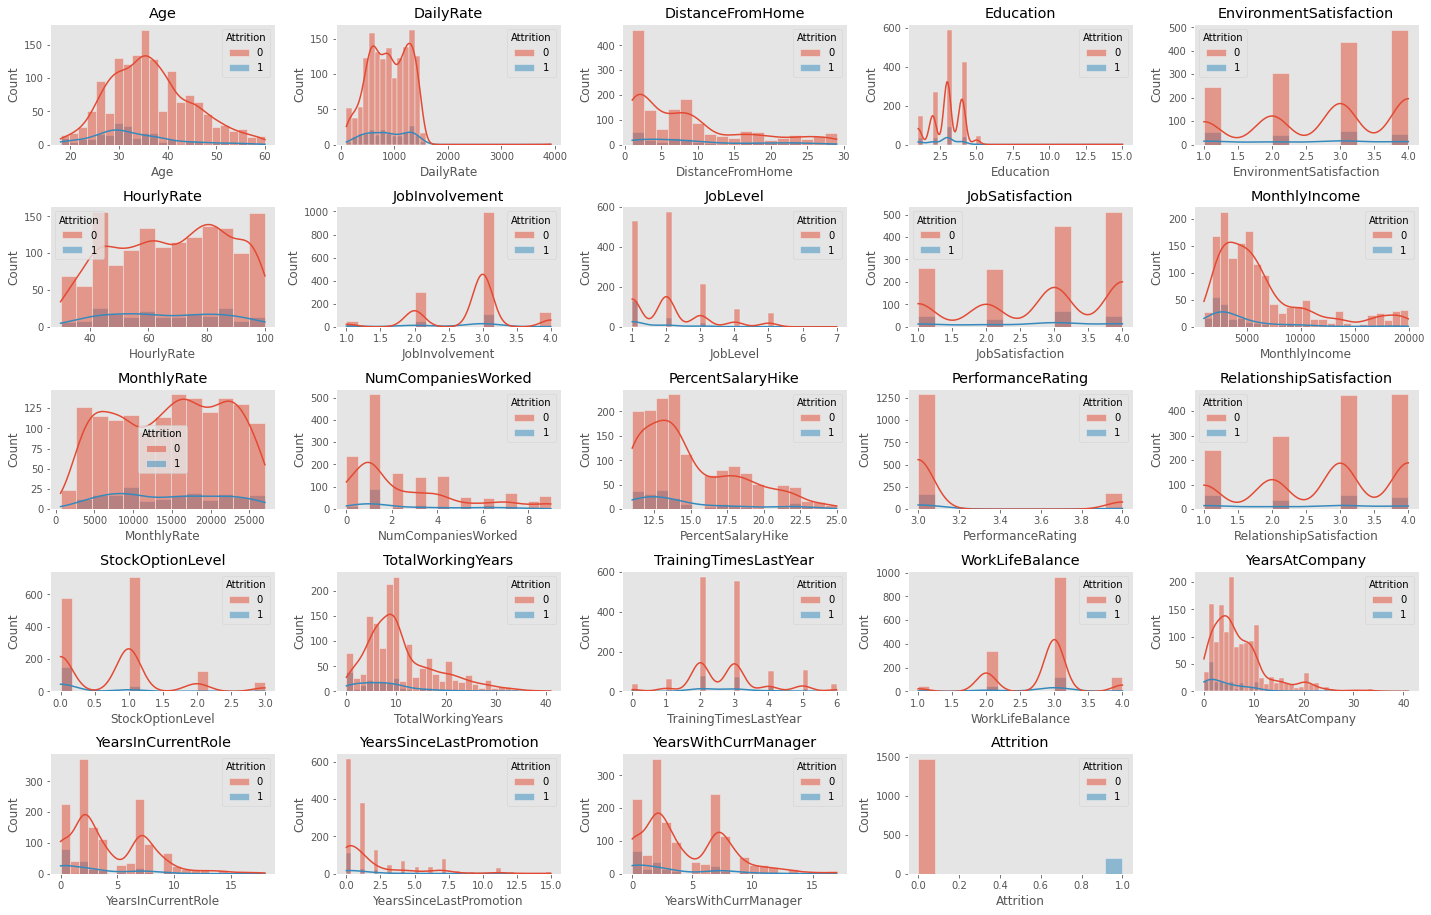

In [32]:
plt.figure(figsize=(20, 25))
for i, column in enumerate(train.select_dtypes("number").columns, 1):
    plt.subplot(10, 5, i)
    plt.title(f"{column}")
    sns.histplot(x=column, data=train, hue="Attrition", kde=True)
    plt.grid(axis="both")
plt.tight_layout()
plt.show()

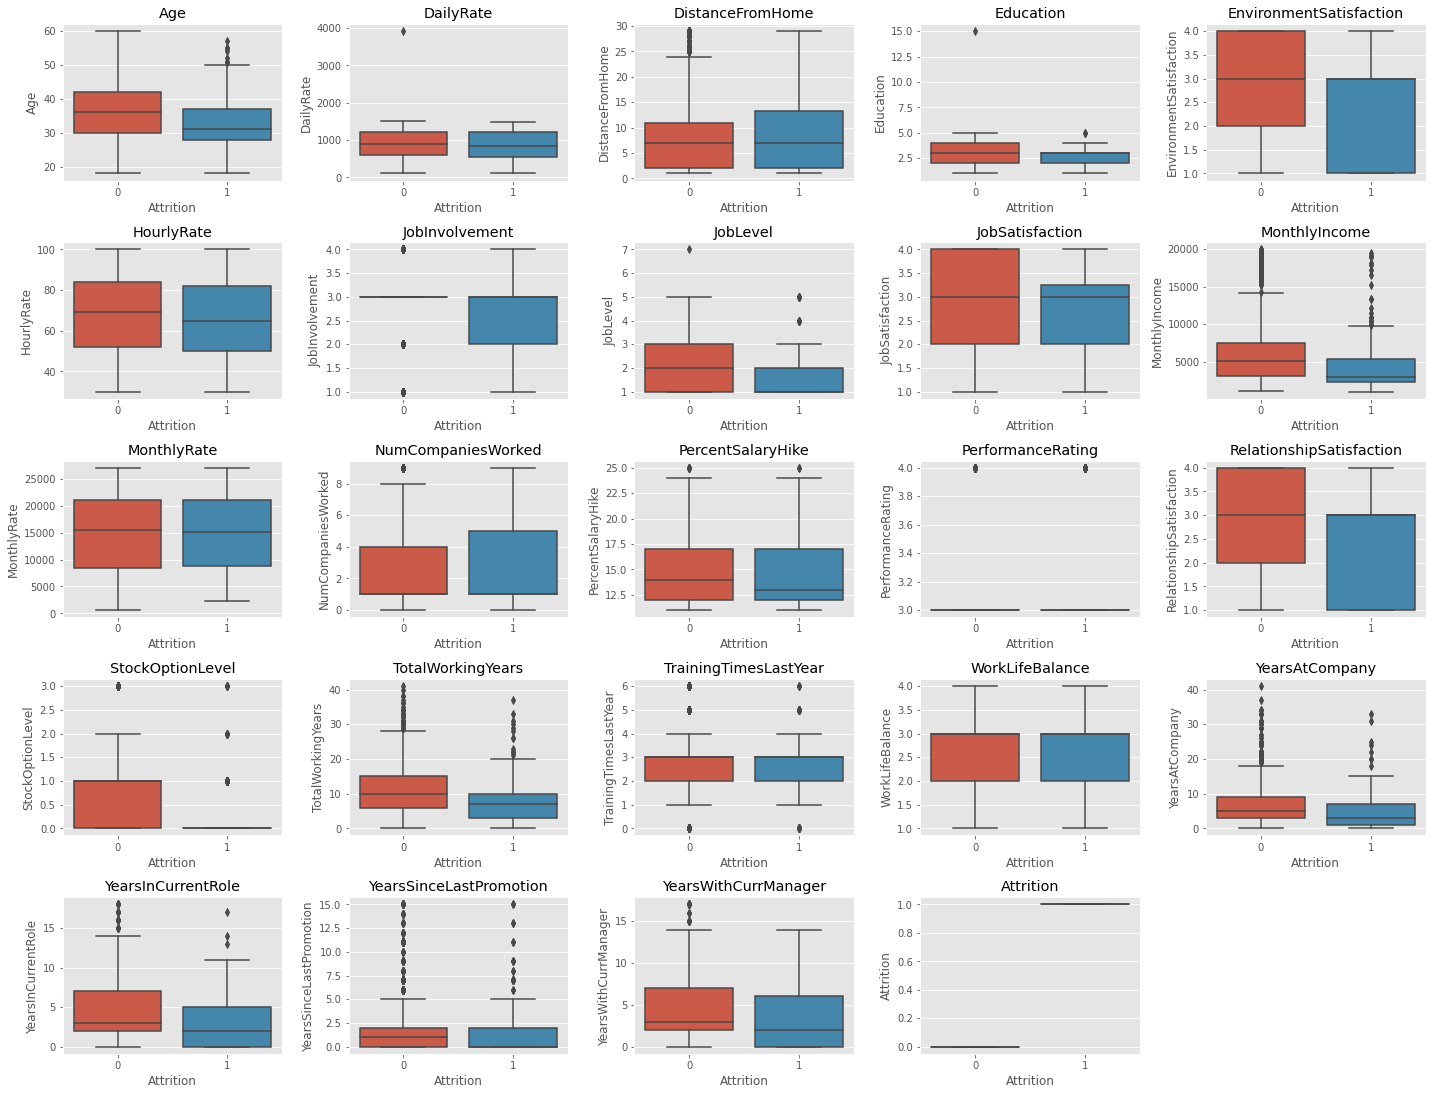

In [33]:
plt.figure(figsize=(20, 30))
for i, column in enumerate(train.select_dtypes("number").columns, 1):
    plt.subplot(10, 5, i)
    plt.title(f"{column}")
    sns.boxplot(x="Attrition", y=column, data=train)
plt.tight_layout()
plt.show()
#+ more old employees exit less: age add qcut categorical
# daily rate outlier?
# distance is not the main reason to exit
# educaton outlier?
#+ who are less satisfied -> exits 
#+ exits one that are less involved in working process
#+ lower job level makes employee to exit
#+ the ones with lower monthly income exit
#+ the ones who are less satisfied with relationships exit
#+ the lower the StockOptionLevel the more employees exit (they are not as much valuebale)
#+ who works less amount of years - exits: age/amt ratio
#+ who spend less amount of years in company - exits: age ratio

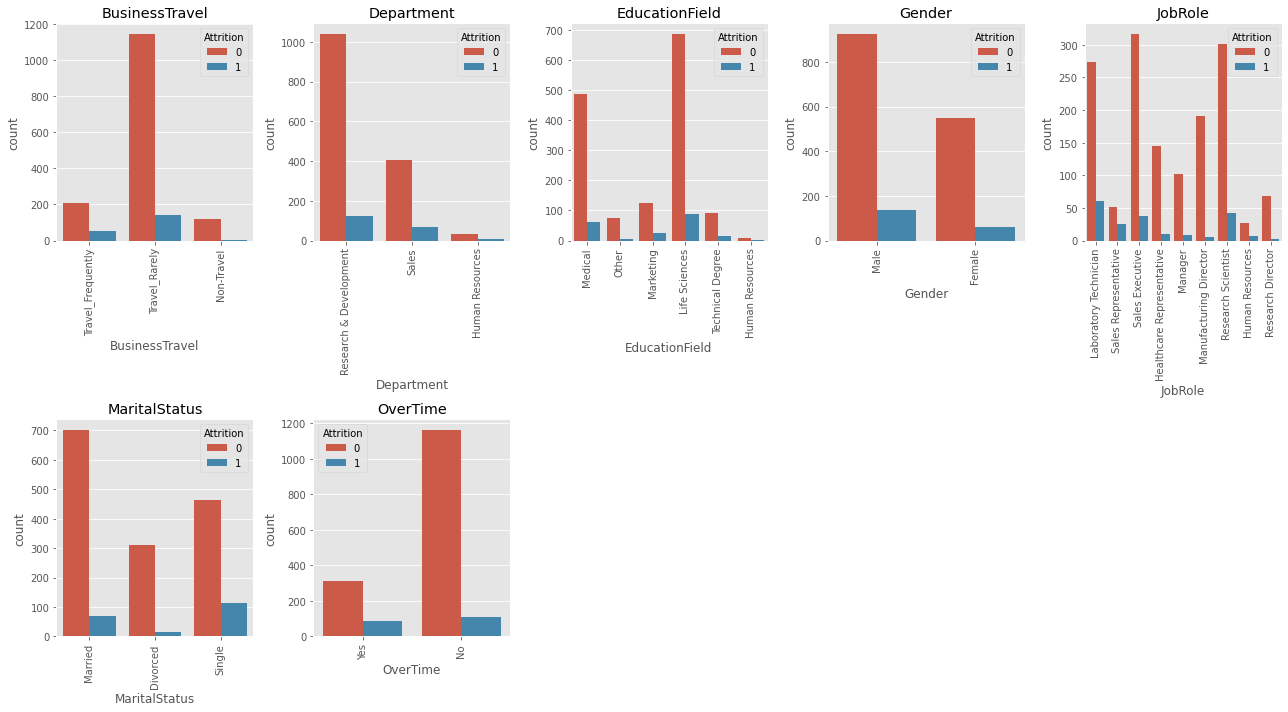

In [49]:
plt.figure(figsize=(18, 10))
for i, column in enumerate(train.select_dtypes("object").columns, 1):
    plt.subplot(2, 5, i)
    plt.title(f"{column}")
    sns.countplot(hue="Attrition", x=column, data=train)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
# who travels a lot are more likely to exit than who travels rarely
# overtimed exit more often
# single employees exit more often
# sales representatives exit more often

* years at company > age? replace with age - 16 (why? - see below)

* "YearsInCurrentRole" < "YearsSinceLastPromotion"?: according to number of rows with such situation: 
maybe promotion means promotion of salary, but not neccessary the role

* daily rate outlier? (outliers in training features are not very harmful with boosting models)
* educaton outlier?

In [60]:
train.loc[train["YearsAtCompany"] > train["Age"] - 16, [col for col in train.columns if col.startswith("Year")]+["Age", "Attrition"]]
# 16 - as maybe employee worked on half-part time, e.g. as courier
# age <= ~ years at company: we cannot drop them as test has the same issues, note that all of them are less than 40 (age)
# seems they worked here for entire professional life
# better replace by [Age - 16]

,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Age,Attrition
id,,,,,,
79,33,10,13,8,35,1
103,8,7,3,7,23,0
115,13,9,4,9,27,0
172,5,2,2,3,20,1
268,20,7,3,7,31,1
311,6,0,1,5,19,0
364,10,9,1,0,18,0
651,15,12,5,10,30,0
838,9,5,0,8,20,0


In [58]:
test.loc[test["YearsAtCompany"] > test["Age"]-16, [col for col in train.columns if col.startswith("Year")]+["Age"]]

,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Age
id,,,,,
1830,13,9,5,9,27
1991,17,14,5,8,31
2002,22,17,13,7,36
2087,8,2,1,2,21
2206,17,8,12,10,30
2389,20,7,0,4,33
2443,3,2,2,2,18
2557,10,0,0,8,25
2637,8,7,0,3,23


In [78]:
train[train["DailyRate"] > 2000]  # extra valuable employee

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1398,44,Travel_Frequently,3921,Research & Development,1,3,Life Sciences,4,Male,73,1,3,Healthcare Representative,4,Married,7336,7439,3,No,12,3,2,1,24,3,3,20,10,3,10,0


In [79]:
train[train["Education"] > 10]  # overeducated employee: optionally clip by 99 percentile

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
527,38,Travel_Rarely,548,Research & Development,1,15,Life Sciences,1,Female,72,3,1,Laboratory Technician,4,Divorced,2644,6217,7,No,13,3,1,1,7,2,3,5,2,1,4,0


In [118]:
train = train.drop(527).drop(1398).reset_index(drop=True)

In [170]:
X, y = train.drop("Attrition", axis=1), train["Attrition"]
categorical = [col for col in X.columns if X[col].dtype == "object"]
for col in categorical:
    X[col] = X[col].astype("str")

In [106]:
# baseline before transforms: as dataset is very small - we will use crossvalidation with 6 folds (~20% split) + Stratified
# strong overfitting is observed

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
baseline_params = {"silent": True, "random_seed": seed}

_, _, _ = catboost_cross_validation(X, y, params=baseline_params, cv=cv, calculate_ci=True, categorical=categorical)

Thu Jan 19 16:58:00 2023, Cross-Validation, 1675 rows, 30 cols
Estimating best number of trees.
Evaluating cross validation with 220 trees.
Fold 1, Train score = 0.99587, Valid score = 0.91033
Fold 2, Train score = 0.99923, Valid score = 0.83420
Fold 3, Train score = 0.94588, Valid score = 0.79084
Fold 4, Train score = 0.99995, Valid score = 0.89973
Fold 5, Train score = 0.97270, Valid score = 0.78997
Fold 6, Train score = 0.98519, Valid score = 0.83541
Train score by each fold: [0.99587, 0.99923, 0.94588, 0.99995, 0.9727, 0.98519]
Valid score by each fold: [0.91033, 0.8342, 0.79084, 0.89973, 0.78997, 0.83541]
Train mean score by each fold:0.98314 +/- 0.01917
Valid mean score by each fold:0.84341 +/- 0.04729
**************************************************
OOF-score roc_auc_score: 0.84238
Expected metric value lies between: 0.81470 and 0.86834  with confidence of 95.0%


In [173]:
# lets define custom parameters
cb_params = {
            "grow_policy": "SymmetricTree",
            "boosting_type": "Ordered",
            "score_function": "Cosine",
            "depth": 3,
            "iterations": 1000,
            "learning_rate": 0.1,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "use_best_model": True,
            "thread_count": -1,
            "silent": True,
            "random_seed": seed,
            "allow_writing_files": False,
            "auto_class_weights": "Balanced",
            "bagging_temperature": 1,
            "max_bin": 16,  # tune
            "l2_leaf_reg": 69,
            "subsample": 0.8,
            "bootstrap_type": "MVS",
            "colsample_bylevel": 0.6,
            # "max_ctr_complexity": 4,
            # "random_strength": 0.8,
}

_, _, _ = catboost_cross_validation(X, y, params=cb_params, rounds=20, cv=cv, calculate_ci=True, categorical=categorical)

Thu Jan 19 18:59:05 2023, Cross-Validation, 1675 rows, 30 cols
Estimating best number of trees.
Evaluating cross validation with 112 trees.
Fold 1, Train score = 0.88729, Valid score = 0.90077
Fold 2, Train score = 0.90710, Valid score = 0.84885
Fold 3, Train score = 0.89987, Valid score = 0.77704
Fold 4, Train score = 0.89230, Valid score = 0.88778
Fold 5, Train score = 0.89909, Valid score = 0.80057
Fold 6, Train score = 0.91523, Valid score = 0.83926
Train score by each fold: [0.88729, 0.9071, 0.89987, 0.8923, 0.89909, 0.91523]
Valid score by each fold: [0.90077, 0.84885, 0.77704, 0.88778, 0.80057, 0.83926]
Train mean score by each fold:0.90015 +/- 0.00916
Valid mean score by each fold:0.84238 +/- 0.04385
**************************************************
OOF-score roc_auc_score: 0.84007
Expected metric value lies between: 0.80943 and 0.86686  with confidence of 95.0%


### FE + F selection by catboost (also woe vs catenc)

In [112]:
# aggs, ratios, counts, multiplies

# we wont do that, skip this step
condition = (train["YearsAtCompany"] > train["Age"] - 16)
train.loc[condition, "YearsAtCompany"] = train.loc[condition, "Age"] - 16

condition = (test["YearsAtCompany"] > test["Age"] - 16)
test.loc[condition, "YearsAtCompany"] = test.loc[condition, "Age"] - 16

check_split_equality(train.drop("Attrition", axis=1), test, categorical=categorical)

CV-score, mean: 0.4909, std: 0.0152


In [115]:
X, y = train.drop("Attrition", axis=1), train["Attrition"]
categorical = [col for col in X.columns if X[col].dtype == "object"]
for col in categorical:
    X[col] = X[col].astype("str")
    
_, _, _ = catboost_cross_validation(X, y, params=cb_params, rounds=20, cv=cv, calculate_ci=True, categorical=categorical)

Thu Jan 19 17:09:14 2023, Cross-Validation, 1675 rows, 30 cols
Estimating best number of trees.
Evaluating cross validation with 60 trees.
Fold 1, Train score = 0.87242, Valid score = 0.89132
Fold 2, Train score = 0.87503, Valid score = 0.82619
Fold 3, Train score = 0.88634, Valid score = 0.78135
Fold 4, Train score = 0.86581, Valid score = 0.86105
Fold 5, Train score = 0.88424, Valid score = 0.80919
Fold 6, Train score = 0.85608, Valid score = 0.81573
Train score by each fold: [0.87242, 0.87503, 0.88634, 0.86581, 0.88424, 0.85608]
Valid score by each fold: [0.89132, 0.82619, 0.78135, 0.86105, 0.80919, 0.81573]
Train mean score by each fold:0.87332 +/- 0.01038
Valid mean score by each fold:0.83080 +/- 0.03591
**************************************************
OOF-score roc_auc_score: 0.82747
Expected metric value lies between: 0.79703 and 0.85686  with confidence of 95.0%


In [135]:
# FE
additional = pd.DataFrame(index=train.index)
additional["AgeCut"] = pd.qcut(train["Age"], q=4, labels=False).astype("str")
additional["EnvPlusRel"] = train["EnvironmentSatisfaction"] + train["RelationshipSatisfaction"]
additional["EnvToRel"] = train["EnvironmentSatisfaction"] / train["RelationshipSatisfaction"]
additional["logEnvToRel"] = np.log1p(additional["EnvToRel"])
additional["JobPlusLevel"] = train["JobInvolvement"] + train["JobLevel"]
additional["StockValued"] = train["StockOptionLevel"] / train["MonthlyIncome"]


list_aggs = ["mean", "max", "min", "count"]
aggs = {"MonthlyIncome": list_aggs,
        "Age": list_aggs,
        "DailyRate": list_aggs,}

stats1 = create_numerical_aggs(train, groupby_id="JobLevel", aggs=aggs, prefix="BY_JobLevel_")
stats2 = create_numerical_aggs(train, groupby_id="EnvironmentSatisfaction", aggs=aggs, prefix="BY_Env_")
stats3 = create_numerical_aggs(train, groupby_id="RelationshipSatisfaction", aggs=aggs, prefix="BY_Rel_")
stats4 = create_numerical_aggs(train, groupby_id="YearsAtCompany", aggs=aggs, prefix="BY_YAC_")
stats5 = create_numerical_aggs(train, groupby_id="JobRole", aggs=aggs, prefix="BY_JR_")
stats6 = create_numerical_aggs(train, groupby_id="EducationField", aggs=aggs, prefix="BY_Edu_")

additional["JobLevel"] = train["JobLevel"].values
additional = pd.merge(additional, stats1, on="JobLevel", how="left")
additional.drop("JobLevel", axis=1, inplace=True)

additional["EnvironmentSatisfaction"] = train["EnvironmentSatisfaction"].values
additional = pd.merge(additional, stats2, on="EnvironmentSatisfaction", how="left")
additional.drop("EnvironmentSatisfaction", axis=1, inplace=True)

additional["RelationshipSatisfaction"] = train["RelationshipSatisfaction"].values
additional = pd.merge(additional, stats3, on="RelationshipSatisfaction", how="left")
additional.drop("RelationshipSatisfaction", axis=1, inplace=True)

additional["YearsAtCompany"] = train["YearsAtCompany"].values
additional = pd.merge(additional, stats4, on="YearsAtCompany", how="left")
additional.drop("YearsAtCompany", axis=1, inplace=True)

additional["JobRole"] = train["JobRole"].values
additional = pd.merge(additional, stats5, on="JobRole", how="left")
additional.drop("JobRole", axis=1, inplace=True)

additional["EducationField"] = train["EducationField"].values
additional = pd.merge(additional, stats6, on="EducationField", how="left")
additional.drop("EducationField", axis=1, inplace=True)

additional["IsYoung"] = 0
additional.loc[train["Age"] <= 25, "IsYoung"] = 1
additional["IsYoung"] = additional["IsYoung"].astype("str")

additional["YoungUnderpaid"] = 0
additional.loc[((train["Age"] <= 25) & (train["DailyRate"] < 500)), "YoungUnderpaid"] = 1
additional["YoungUnderpaid"] = additional["YoungUnderpaid"].astype("str")

additional["WorklifeStock"] = train["WorkLifeBalance"] + train["StockOptionLevel"]
additional["WorklifeStock"] = train["WorkLifeBalance"] * train["StockOptionLevel"]

additional["AgeToSalary"] = train["MonthlyIncome"] / train["Age"]
additional["WorkToAge"] = train["TotalWorkingYears"] / train["Age"]
additional["YearsToAge"] = train["YearsAtCompany"] / train["Age"]

additional["DayToMonth"] = train["MonthlyIncome"] / train["DailyRate"]

In [ ]:
total = pd.concat([train, additional], axis=1).drop("Attrition", axis=1)
feature_names = list(total.columns)
cat_cols = [col for col in total.columns if total[col].dtype == "object"]
cat_indices = [i for i, col in enumerate(total.columns) if col in cat_cols]

x_train, x_test, y_train, y_test = train_test_split(total, y, shuffle=True, test_size=0.2, stratify=y, random_state=seed)

train_pool = Pool(x_train, y_train, feature_names=feature_names, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, feature_names=feature_names, cat_features=cat_cols)

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(**cb_params)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=30,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

In [144]:
features = ['Age', 'JobInvolvement', 'NumCompaniesWorked', 'OverTime', 'StockOptionLevel', 'YearsInCurrentRole', 
             'JobPlusLevel', 'StockValued', 'BY_JOBLEVEL_MONTHLYINCOME_MIN', 'BY_JOBLEVEL_DAILYRATE_MEAN', 
            'BY_JOBLEVEL_DAILYRATE_COUNT', 'BY_ENV_MONTHLYINCOME_MEAN', 'BY_ENV_MONTHLYINCOME_MIN', 
            'BY_ENV_MONTHLYINCOME_COUNT', 'BY_ENV_AGE_MEAN', 'BY_ENV_DAILYRATE_COUNT', 'BY_REL_MONTHLYINCOME_MAX', 
            'BY_REL_MONTHLYINCOME_MIN', 'BY_REL_DAILYRATE_MAX', 'BY_YAC_MONTHLYINCOME_MEAN', 'BY_YAC_MONTHLYINCOME_MAX', 
            'BY_YAC_AGE_MEAN', 'BY_YAC_DAILYRATE_MEAN', 'BY_JR_MONTHLYINCOME_MEAN', 'BY_JR_MONTHLYINCOME_MAX', 
            'BY_JR_MONTHLYINCOME_MIN', 'BY_JR_AGE_MAX', 'BY_JR_DAILYRATE_MIN', 'WorklifeStock', 'YearsToAge']
sel_cat = [col for col in total[features].columns if total[col].dtype == "object"]
for col in sel_cat:
    total[col] = total[col].astype("str")

In [146]:
_, _, _ = catboost_cross_validation(total[features], y, params=cb_params, rounds=20, cv=cv, calculate_ci=True, categorical=sel_cat)

Thu Jan 19 18:13:16 2023, Cross-Validation, 1675 rows, 30 cols
Estimating best number of trees.
Evaluating cross validation with 27 trees.
Fold 1, Train score = 0.84720, Valid score = 0.88749
Fold 2, Train score = 0.85712, Valid score = 0.81812
Fold 3, Train score = 0.85696, Valid score = 0.74618
Fold 4, Train score = 0.84733, Valid score = 0.84799
Fold 5, Train score = 0.85291, Valid score = 0.79995
Fold 6, Train score = 0.85692, Valid score = 0.81927
Train score by each fold: [0.8472, 0.85712, 0.85696, 0.84733, 0.85291, 0.85692]
Valid score by each fold: [0.88749, 0.81812, 0.74618, 0.84799, 0.79995, 0.81927]
Train mean score by each fold:0.85307 +/- 0.00435
Valid mean score by each fold:0.81983 +/- 0.04319
**************************************************
OOF-score roc_auc_score: 0.81893
Expected metric value lies between: 0.78728 and 0.84864  with confidence of 95.0%


In [150]:
for fold, (train_idx, valid_idx) in enumerate(StratifiedKFold(n_splits=6, shuffle=True, random_state=seed%3).split(X, y)):
    if fold == 2:
        x_train = X.loc[train_idx]
        y_train = y[train_idx]

In [151]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=100, contamination=0.01, bootstrap=True, random_state=seed)
outliers = iso.fit_predict(x_train.select_dtypes("number"))

pd.concat([x_train, y_train], axis=1)[outliers == -1]
# old employees with high rates make shift in predictions, maybe select another seed

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
130,46,Travel_Rarely,1319,Research & Development,1,3,Medical,1,Male,68,1,5,Research Director,1,Divorced,18711,13934,7,No,11,3,2,3,27,2,1,24,7,13,13,0
167,55,Travel_Frequently,1377,Research & Development,19,2,Medical,1,Male,58,3,5,Manager,4,Single,19038,7693,3,No,11,3,4,0,37,4,2,24,7,15,11,1
229,52,Travel_Rarely,1445,Research & Development,2,4,Medical,3,Female,45,2,5,Research Director,2,Single,19038,19805,1,No,12,3,1,0,34,2,2,34,16,1,1,0
234,53,Travel_Rarely,1040,Sales,2,1,Marketing,2,Male,95,3,4,Manager,4,Divorced,16856,22376,4,No,15,3,4,1,30,5,4,29,6,11,10,0
451,45,Travel_Frequently,530,Sales,29,3,Marketing,3,Female,52,3,3,Sales Executive,1,Divorced,10453,16376,1,No,21,4,1,2,24,0,3,24,9,13,10,0
579,46,Non-Travel,1223,Sales,6,3,Marketing,3,Female,33,4,5,Manager,3,Married,18172,4652,1,No,21,4,1,1,26,2,2,26,14,12,7,0
586,51,Travel_Frequently,397,Human Resources,2,5,Life Sciences,4,Male,91,1,5,Manager,4,Married,19068,15682,0,No,13,3,2,0,34,3,3,33,10,4,13,0
621,44,Travel_Rarely,1252,Research & Development,26,1,Medical,1,Male,94,2,3,Healthcare Representative,3,Married,10748,4605,0,No,25,4,1,1,24,1,3,20,17,3,13,0
810,51,Travel_Frequently,566,Research & Development,19,2,Medical,4,Male,42,3,4,Manager,3,Married,17169,19764,7,No,12,3,3,1,22,2,1,18,17,15,13,1
1083,52,Travel_Rarely,638,Sales,7,5,Marketing,4,Female,62,3,5,Manager,2,Married,19068,17011,1,No,15,3,3,1,33,3,3,33,14,1,15,0


In [152]:
for fold, (train_idx, valid_idx) in enumerate(StratifiedKFold(n_splits=6, shuffle=True, random_state=seed%3).split(X, y)):
    if fold == 0:
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

In [157]:
scores, deltas = calculate_permutation_importance(CatBoostClassifier(**cb_params).fit(total.loc[train_idx], 
                                                                     y[train_idx],
                                                                     eval_set=[(total.loc[valid_idx], y[valid_idx]),],
                                                                     cat_features=cat_cols),
                                 roc_auc_score,
                                 total.loc[valid_idx],
                                 y[valid_idx],
                                 maximize=True,
                                 probas=True
                                 )

100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 230.14it/s]


In [159]:
deltas = deltas[deltas > 0].index.tolist()

In [160]:
delta_cats = [col for col in total[deltas].columns if total[col].dtype == "object"]
for col in delta_cats:
    total[col] = total[col].astype("str")

In [161]:
_, _, _ = catboost_cross_validation(total[deltas], y, params=cb_params, rounds=20, cv=cv, calculate_ci=True, 
                                    categorical=delta_cats)

Thu Jan 19 18:30:43 2023, Cross-Validation, 1675 rows, 27 cols
Estimating best number of trees.
Evaluating cross validation with 21 trees.
Fold 1, Train score = 0.80917, Valid score = 0.87829
Fold 2, Train score = 0.84633, Valid score = 0.81110
Fold 3, Train score = 0.84833, Valid score = 0.77082
Fold 4, Train score = 0.84088, Valid score = 0.84559
Fold 5, Train score = 0.84685, Valid score = 0.79878
Fold 6, Train score = 0.84704, Valid score = 0.79508
Train score by each fold: [0.80917, 0.84633, 0.84833, 0.84088, 0.84685, 0.84704]
Valid score by each fold: [0.87829, 0.8111, 0.77082, 0.84559, 0.79878, 0.79508]
Train mean score by each fold:0.83977 +/- 0.01389
Valid mean score by each fold:0.81661 +/- 0.03548
**************************************************
OOF-score roc_auc_score: 0.81243
Expected metric value lies between: 0.78212 and 0.84140  with confidence of 95.0%


In [179]:
class CustomWOEEncoder(BaseEstimator, TransformerMixin):
    """ use inside cross-val function """
    def __init__(self, categorical):
        self.categorical = categorical
        
    def fit(self, X, y=None):
        
        self.all_columns = X.columns.tolist()
        
        for column in self.categorical:
            X[column] = X[column].astype("str")
            
        self.encoder = WOEEncoder(drop_invariant=True, randomized=True)
        self.encoder.fit(X, y, cols=self.categorical)
        
        return self
    
    def transform(self, X):
        X = X.copy(deep=True)
        
        for column in self.categorical:
            X[column] = X[column].astype("str")
        
        X = self.encoder.transform(X)
        X = pd.DataFrame(data=X, columns=self.all_columns)
        
        return X     

In [182]:
# following best-scored kernels: try to add ["IsYoung", "WorklifeStock", "YoungUnderpaid"] with new seed=34
# new categorical features and WoE encoding

X, y = train.drop("Attrition", axis=1), train["Attrition"]
X = pd.concat([X, additional[["IsYoung", "WorklifeStock", "YoungUnderpaid"]]], axis=1)

cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
                'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus','NumCompaniesWorked', 'OverTime', 
                'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
                'IsYoung', 'YoungUnderpaid']

for col in cat_features:
    X[col] = X[col].astype("str")
    
_, _, _ = catboost_cross_validation(X, y, 
                                    params=cb_params, 
                                    rounds=50, 
                                    cv=cv, 
                                    calculate_ci=True, 
                                    categorical=None,
                                    preprocess=CustomWOEEncoder(cat_features),
                                    seed=123)

Thu Jan 19 19:05:31 2023, Cross-Validation, 1675 rows, 33 cols
Estimating best number of trees.
Evaluating cross validation with 62 trees.
Fold 1, Train score = 0.89787, Valid score = 0.87386
Fold 2, Train score = 0.90623, Valid score = 0.84504
Fold 3, Train score = 0.89404, Valid score = 0.78849
Fold 4, Train score = 0.89594, Valid score = 0.85403
Fold 5, Train score = 0.90431, Valid score = 0.80562
Fold 6, Train score = 0.88682, Valid score = 0.82413
Train score by each fold: [0.89787, 0.90623, 0.89404, 0.89594, 0.90431, 0.88682]
Valid score by each fold: [0.87386, 0.84504, 0.78849, 0.85403, 0.80562, 0.82413]
Train mean score by each fold:0.89753 +/- 0.00647
Valid mean score by each fold:0.83186 +/- 0.02904
**************************************************
OOF-score roc_auc_score: 0.83184
Expected metric value lies between: 0.80297 and 0.86107  with confidence of 95.0%


In [186]:
# optuna
start_params = {
                "grow_policy": "SymmetricTree",
                "boosting_type": "Ordered",
                "score_function": "Cosine",
                "iterations": 1000,
                "loss_function": "Logloss",
                "eval_metric": "AUC",
                "task_type": "CPU",
                "use_best_model": True,
                "thread_count": -1,
                "silent": True,
                "random_seed": seed,
                "allow_writing_files": False,
                "bootstrap_type": "MVS",
        }


def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 5),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ["Balanced", None, "SqrtBalanced"]),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 30),
                    'max_bin': trial.suggest_int('max_bin', 10, 255),
                    'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 0, 150),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.0),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.0),
                    }
    
    param_trials.update(start_params)

    fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
    
    _, _, score = catboost_cross_validation(X, y, 
                                            params=param_trials,
                                            score_fn=roc_auc_score,
                                            rounds=30, 
                                            cv=fold, 
                                            calculate_ci=False, 
                                            categorical=None,
                                            verbose=False,
                                            preprocess=CustomWOEEncoder(cat_features),
                                            seed=123)
    
    return score

In [189]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=10000, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 2156
Best trial
Best score: 0.8614283333333334
Best params
{'auto_class_weights': None,
 'bagging_temperature': 17.272447093356615,
 'colsample_bylevel': 0.33077645106640063,
 'depth': 4,
 'l2_leaf_reg': 75,
 'learning_rate': 0.28855676667209984,
 'max_bin': 217,
 'subsample': 0.7743091951895116}
CPU times: total: 125 ms
Wall time: 124 ms


In [198]:
optim_cb_params = {
                "grow_policy": "SymmetricTree",
                "boosting_type": "Ordered",
                "score_function": "Cosine",
                "iterations": 1000,
                "loss_function": "Logloss",
                "eval_metric": "AUC",
                "task_type": "CPU",
                "use_best_model": True,
                "thread_count": -1,
                "silent": True,
                "random_seed": seed,
                "allow_writing_files": False,
                "bootstrap_type": "MVS",
                'auto_class_weights': None,
                'bagging_temperature': 17.272447093356615,
                'colsample_bylevel': 0.33077645106640063,
                'depth': 4,
                'l2_leaf_reg': 75,
                'learning_rate': 0.28855676667209984,
                'max_bin': 217,
                'subsample': 0.7743091951895116
        }

fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)

_, _, score = catboost_cross_validation(X, y, 
                                        params=optim_cb_params,
                                        score_fn=roc_auc_score,
                                        rounds=30, 
                                        cv=fold, 
                                        calculate_ci=True, 
                                        categorical=None,
                                        verbose=True,
                                        preprocess=CustomWOEEncoder(cat_features),
                                        seed=123)

Thu Jan 19 22:12:19 2023, Cross-Validation, 1675 rows, 33 cols
Estimating best number of trees.
Evaluating cross validation with 75 trees.
Fold 1, Train score = 0.88628, Valid score = 0.90686
Fold 2, Train score = 0.94248, Valid score = 0.86770
Fold 3, Train score = 0.90846, Valid score = 0.79256
Fold 4, Train score = 0.94400, Valid score = 0.90182
Fold 5, Train score = 0.92827, Valid score = 0.83432
Fold 6, Train score = 0.91848, Valid score = 0.86531
Train score by each fold: [0.88628, 0.94248, 0.90846, 0.944, 0.92827, 0.91848]
Valid score by each fold: [0.90686, 0.8677, 0.79256, 0.90182, 0.83432, 0.86531]
Train mean score by each fold:0.92133 +/- 0.02005
Valid mean score by each fold:0.86143 +/- 0.03922
**************************************************
OOF-score roc_auc_score: 0.85931
Expected metric value lies between: 0.83188 and 0.88793 with confidence of 95.0%


In [ ]:
# check for split equality (test, train) after transforms
# train model on full dataset, add few trees